In [8]:
import tensorflow as tf
import torch


# If there's a GPU available
if torch.cuda.is_available():    

    # Tells PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1080


In [9]:
import numpy as np
import pandas as pd

In [10]:
df = pd.read_excel("cleaned_data.xlsx")

In [11]:
df = df.drop(df.columns[[0]], axis=1)

In [12]:
#class label 0 - hate speech 1 - offensive language 2 - neither

In [13]:
# Show number of data entries
print('Number of data entries: {}'.format(len(df)))

# Show a few samples
df.sample(3)

Number of data entries: 24782


,class,tweet
21970,1,This bitch is raising MY anxiety just by sitti...
19360,1,: anxiety is such a cunt
19491,1,": "" IM CRYING that bitch going hard"


In [14]:
from sklearn.model_selection import train_test_split

#70-30 on train and test
df_base,df_test = train_test_split(df,
                                   random_state = 12345, 
                                   test_size = 0.3,
                                  stratify = df['class'])
#90-10 on train and validation
df_train, df_val = train_test_split(df_base, 
                                    random_state = 12345, 
                                    test_size = 0.1, 
                                    stratify = df_base['class'])

In [15]:
for item in df_train, df_val:
    print('Shape: {}'.format(item.shape))

Shape: (15612, 2)
Shape: (1735, 2)


In [16]:
from transformers import BertTokenizer
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
# Create lists for encoded text data
def get_encoded_dict(df):
    input_ids = []
    attention_mask = []

    for text in df['tweet']:
        encoded = tokenizer.encode_plus(text,
                                        add_special_tokens=True,
                                        pad_to_max_length=True,
                                        return_attention_mask=True,
                                        max_length=64,
                                        return_tensors='pt',
                                        truncation=True)

        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
        
    return input_ids, attention_mask

In [18]:
# Cat lists to tensors for TensorDataset
def get_tensors(input_ids, attention_mask):
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0)
    
    return input_ids, attention_mask

In [19]:
# Import tools for Dataloader
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

# Convert df to DataLoader
def get_dataloader(df):
    batch_size=16
    temp_ids, temp_masks = get_encoded_dict(df)
    
    # Convert to tensors
    temp_ids, temp_masks = get_tensors(temp_ids, temp_masks)
    temp_labels = torch.tensor(df['class'].values)
    
    # Generate dataset
    temp_dataset = TensorDataset(temp_ids,
                                 temp_masks,
                                 temp_labels)
    
    # Generate dataloader
    temp_dataloader = DataLoader(temp_dataset,
                                 batch_size=batch_size,
                                 sampler=RandomSampler(temp_dataset))
    
    return temp_dataloader

In [20]:
# Get dataloader for all dataframes
train_dataloader = get_dataloader(df_train)
val_dataloader = get_dataloader(df_val)



C:\Users\xaris\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [21]:
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
# Tell mode to use CUDA
model.cuda()





Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [22]:
# Configuring optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5)

In [23]:


# Configuring scheduler
from transformers import get_linear_schedule_with_warmup

epochs = 2

# Total steps: number of batchers * epochs
total_steps = len(train_dataloader) * epochs

# Set up the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=10,
                                            num_training_steps=total_steps)



In [24]:
# Import materics for evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [25]:
# Reset history lists
history_training_loss = []
history_val_loss = []
history_val_acc = []

for epoch_i in range(epochs):
    
    print('【EPOCH: {}/ {}】'.format(epoch_i+1, epochs))
    print('Trainig Phase')
    
    # Set training mode
    model.train()
    
    # Reset training loss
    total_training_loss = 0.
    
    # Batch and forward
    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        # Reset gradients before 
        model.zero_grad()
        
        # Forward pass
        res = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_masks,
                    return_dict=True,
                    labels=b_labels)
        
        loss = res.loss
        logits = res.logits
        
        # sumup training loss
        total_training_loss += loss.item()
        
        # backpropagation
        loss.backward()
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update optimizer and scheduler
        optimizer.step()
        scheduler.step()
        
    # averrage loss
    avg_train_loss = total_training_loss/len(train_dataloader)
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    
    # append the loss data to history
    history_training_loss.append(avg_train_loss)
    
    # validation
    print('Validation Phase')
    
    # Reset validation loss
    total_val_loss = 0
    
    # Set up lists
    ls_val_logits = []
    ls_val_labels = []

    # Get batchs from val_dataloader
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        # No need to calculate gradients
        with torch.no_grad():

            res = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_masks,
                        labels=b_labels,
                        return_dict=True)

        val_loss = res.loss
        val_logits = res.logits
        total_val_loss += val_loss.item()

        # Convert logitis to numpy format
        val_logits = np.argmax(val_logits.cpu().detach().numpy(), axis=1)
        val_labels = b_labels.cpu().detach().numpy()

        # Append data to the lists
        for logit in val_logits:
            ls_val_logits.append(logit)

        for label in val_labels:
            ls_val_labels.append(label)
    
    # Get accuracy score and val_loss
    acc = accuracy_score(ls_val_logits, ls_val_labels)
    avg_val_loss = total_val_loss/len(val_dataloader)
    
    # append validation data to history
    history_val_acc.append(acc)
    history_val_loss.append(avg_val_loss)
    
    # Print out validation performance
    print('  Average validation loss: {:.4f}'.format(avg_val_loss))
    print('  Validation accruacy: {:.4f}'.format(acc))
    print('\n')

【EPOCH: 1/ 2】
Trainig Phase
  Average training loss: 0.3335
Validation Phase
  Average validation loss: 0.2495
  Validation accruacy: 0.9089


【EPOCH: 2/ 2】
Trainig Phase
  Average training loss: 0.2246
Validation Phase
  Average validation loss: 0.2504
  Validation accruacy: 0.9147




 
 
 
 Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data.


Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on.

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, 
while accuracy will not.




In [26]:
# Convert histroy to dataframe
cols = ['loss', 'val_loss', 'val_acc']

history = np.stack((
                    np.array(history_training_loss),        
                    np.array(history_val_loss),
                    np.array(history_val_acc),
                    ), axis=1)

df_history = pd.DataFrame(history, columns=cols)

# Show df_history
df_history

,loss,val_loss,val_acc
0,0.333467,0.249527,0.908934
1,0.224641,0.250400,0.914697


Text(0.5, 1.0, 'accuracy')

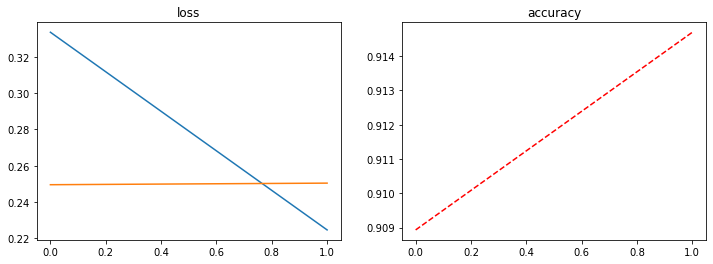

In [27]:


# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(df_history['loss'])
plt.plot(df_history['val_loss'])
plt.title('loss')

plt.subplot(1,2,2)
plt.plot(df_history['val_acc'], color='red', linestyle='--')
plt.title('accuracy')



In [28]:
df_test

,class,tweet
20287,1,: We live In a world full of unloyal hoes ugly...
18216,1,: grab me some bitches while u up there lmao o...
20167,1,": from tonight: "" N word or cracker. . . which..."
16250,1,: Let me make this clear I don't need no fucki...
14276,1,: ELI Manning is fucking trash rap
...,...,...
20502,1,Really. 3 hours to find paper work is retarded...
16686,1,: just knowing U can still go out and bag some...
4377,0,it was Paul McCartney faggot
6200,1,do it you pussy


C:\Users\xaris\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='class', ylabel='count'>

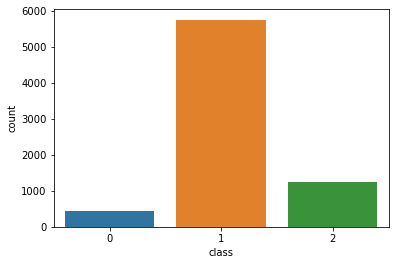

In [29]:
import seaborn as sns
sns.countplot(df_test['class'])

In [30]:
# Prepare df_test for prediction
t_input_ids, t_attention_mask = get_encoded_dict(df_test)
t_input_ids, t_attention_mask = get_tensors(t_input_ids, t_attention_mask)

# Prepare dataset and dataloader
test_dataset = TensorDataset(t_input_ids, t_attention_mask)
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             sampler=SequentialSampler(test_dataset))

# Show dataloader length
print('Number of batches in the dataloader: {}'.format(len(test_dataloader)))

C:\Users\xaris\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Number of batches in the dataloader: 233


In [31]:
# Setup lists for predictions and labels
ls_test_pred = []

# Get batchs from test_dataloader
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_masks = batch[1].to(device)
    
    with torch.no_grad():

        res = model(b_input_ids,
                    attention_mask=b_masks,
                    return_dict=True)

        test_logits = res.logits
        test_logits = np.argmax(test_logits.cpu().detach().numpy(), axis=1)
        
        for pred in test_logits:
            ls_test_pred.append(pred)
            
print(len(ls_test_pred))

7435


In [32]:


# Set up list of test labels
ls_test_labels = list(df_test['class'].values)

# Get accuracy score and val_loss
acc = accuracy_score(ls_test_pred, ls_test_labels)
print('Prediction accuracy: {:.4f}'.format(acc))



Prediction accuracy: 0.9131


<AxesSubplot:>

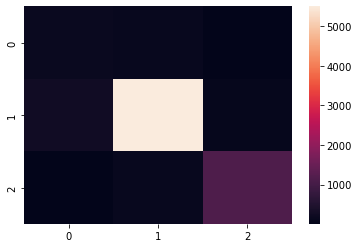

In [33]:
# Confusion matrix
cm = confusion_matrix(ls_test_pred, ls_test_labels)

sns.heatmap(cm)

In [34]:
# Classification report
cr = classification_report(ls_test_pred, ls_test_labels)

print(cr)

              precision    recall  f1-score   support

           0       0.34      0.52      0.41       279
           1       0.95      0.94      0.95      5839
           2       0.92      0.87      0.89      1317

    accuracy                           0.91      7435
   macro avg       0.74      0.78      0.75      7435
weighted avg       0.93      0.91      0.92      7435

